# Preparing data for Modelling

In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer
from sklearn.base import clone

import seaborn as sns

import quantstats as qs
import os 
# pd.set_option('display.max_rows', None)
import os 

# To automatically load changes in different files 
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns 
import matplotlib.pyplot as plt 
# Applying Settings to Viaualization Tools 
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Set color palette to blue shades
sns.set_palette(["#003366", "#6699CC", "#99CCFF", "#99CCFF"])
sns.set_palette(["#002855", "#3E7EAA", "#82B5D8", "#B3D9F2"])
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style("darkgrid")

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, mean_absolute_percentage_error
import statsmodels.api as sm

In [2]:
from utils import search_folder
current_dir = os.getcwd()
thesis_folder_path = current_dir.replace("thesis_code", "")
twitter_data_path = search_folder(thesis_folder_path,"twitter_data")
eikon_data_path = search_folder(thesis_folder_path,"eikon_news")
stock_data_path = search_folder(thesis_folder_path,"stock_prices")
modelling_data_path = search_folder(thesis_folder_path,"modelling_data")
google_trending_path = search_folder(thesis_folder_path,"google_search")

In [3]:
def read_modelling(path, name):
    df = pd.read_csv(path+name)
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.sort_values(by = "datetime", ascending = True)
    df = df.reset_index(drop = True)
    return df

---
## Stock Data 

In [4]:
stock_data_df = read_modelling(modelling_data_path, "/all_stocks_returns_df.csv")
stock_data_df.head(3)

,datetime,close,net,ret,open,low,high,volume,turnover_usd,flow,company
0,2017-01-03,14.465986,NaN,NaN,14.323986,14.063986,14.688652,8.884890e+07,1.283684e+09,0.000000e+00,tesla
1,2017-01-03,29.037500,NaN,NaN,28.950000,28.690000,29.082500,1.151275e+08,3.327549e+09,0.000000e+00,apple
2,2017-01-04,29.005000,-0.0325,-0.001119,28.962500,28.937500,29.127500,8.447246e+07,2.452484e+09,-2.452484e+09,apple


---
## Fama French Model Features 

In [5]:
fama_french_feat_df = read_modelling(modelling_data_path, "/fama_variables_companies.csv")
fama_french_feat_df.head(3)

,datetime,beta_mktrf,beta_smb,beta_hml,beta_rmw,beta_cma,idvar_ff5,company
0,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,moderna
1,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,tesla
2,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,apple


In [6]:
# # joining stock data with fama french factors
# master_table = pd.merge(stock_data_df, fama_french_feat_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
# master_table = master_table.drop_duplicates()

---
## Twitter Sentiment Model Features 

In [7]:
sentiment_df = pd.read_csv(modelling_data_path + "/master_table_news_sentiment.csv")
sentiment_df["datetime"] = pd.to_datetime(sentiment_df["date"], utc = True)
sentiment_df = sentiment_df.sort_values(by = "datetime")
sentiment_df

,date,company,daytweets,textblob_tw_sw,vader_tw_sw,finbert_tw_sw,textblob_senti_sw,vader_sw,finbert_senti_sw,textblob_senti_tw,...,textblob_tw_sw_norm,textblob_eik_sw_norm,finbert_tw_sw_norm,finbert_eik_sw_norm,vader_tw_sw_normalized,vader_eik_sw_normalized,textblob_eik_twi_senti,finbert_eik_twi_senti,vader_eik_twi_senti,datetime
0,2017-01-02,apple,195364,108.654740,145.5335,-35.0,50.796503,476,-22.0,57.858238,...,0.158749,0.399239,0.741854,0.581560,0.462968,0.525878,0.139497,0.330854,0.247211,2017-01-02 00:00:00+00:00
1,2017-01-02,google,32400,27.841547,4.7608,-50.0,11.939170,203,-23.0,15.902377,...,0.076132,0.392872,0.738412,0.624113,0.383226,0.531581,0.117251,0.340631,0.228702,2017-01-02 00:00:00+00:00
2,2017-01-02,tesla,27556,69.120491,56.5365,15.0,25.982624,181,0.0,43.137866,...,0.118332,0.392872,0.753327,0.617021,0.412555,0.531581,0.127801,0.342587,0.236034,2017-01-02 00:00:00+00:00
3,2017-01-03,apple,187489,100.070978,73.2125,-24.0,49.393965,462,-12.0,50.677013,...,0.149973,0.392872,0.744378,0.624113,0.422001,0.531581,0.135711,0.342123,0.238395,2017-01-03 00:00:00+00:00
4,2017-01-03,google,15876,19.047536,36.4611,-18.0,9.819791,135,-9.0,9.227745,...,0.067141,0.392872,0.745755,0.624113,0.401183,0.531581,0.115003,0.342467,0.233191,2017-01-03 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6210,2023-04-13,moderna,25,4.696667,2.5965,5.0,2.348333,5,3.0,2.348333,...,0.052470,0.392872,0.751033,0.624113,0.382000,0.531581,0.111336,0.343787,0.228395,2023-04-13 00:00:00+00:00
6213,2023-04-14,google,961,6.778229,8.8280,-10.0,2.089114,34,-4.0,4.689114,...,0.054598,0.392872,0.747591,0.624113,0.385530,0.531581,0.111868,0.342926,0.229278,2023-04-14 00:00:00+00:00
6214,2023-04-14,moderna,289,3.375763,4.5592,16.0,1.622256,18,8.0,1.753506,...,0.051120,0.392872,0.753557,0.624113,0.383112,0.531581,0.110998,0.344418,0.228673,2023-04-14 00:00:00+00:00
6212,2023-04-14,apple,13924,42.478908,52.1386,8.0,23.767439,126,1.0,18.711469,...,0.091096,0.392872,0.751721,0.624113,0.410063,0.531581,0.120992,0.343959,0.235411,2023-04-14 00:00:00+00:00


---
## Eikon Sentiment  Features 

---
## Topic Modelling Features

---
## Google Trending News for Companies

In [8]:
comp_google_search_df = read_modelling(modelling_data_path, "/google_searches_companies.csv")
comp_google_search_df.head()

,datetime,interest,company
0,2018-04-08,31,apple
1,2018-04-15,1,moderna
2,2018-04-15,33,apple
3,2018-04-15,18,tesla
4,2018-04-22,31,apple


In [9]:
from utils import fix_dates
comp_google_search_df["datetime"] = comp_google_search_df["datetime"].apply(lambda x: fix_dates(x))
comp_google_search_df.head()

,datetime,interest,company
0,2018-04-09,31,apple
1,2018-04-16,1,moderna
2,2018-04-16,33,apple
3,2018-04-16,18,tesla
4,2018-04-23,31,apple


---
## Google Trending News for Macro-News

In [10]:
makro_google_search_df = read_modelling(modelling_data_path, "/google_macro_searches.csv")
makro_google_search_df.head(3)

,datetime,pandemic_mentions,inflation_mentions
0,2018-04-08,1,17
1,2018-04-15,1,16
2,2018-04-22,1,17


In [11]:
makro_google_search_df["datetime"] = makro_google_search_df["datetime"].apply(lambda x: fix_dates(x))
makro_google_search_df.head(3)

,datetime,pandemic_mentions,inflation_mentions
0,2018-04-09,1,17
1,2018-04-16,1,16
2,2018-04-23,1,17


---
## Macro-Economic Data

In [12]:
macro_data_df = read_modelling(modelling_data_path, "/macro_data.csv")
macro_data_df.head(3)

,datetime,euro_doll_bid,euro_doll_ask,eur_doll_high,eur_doll_low,eur_doll_open,refresh_rate,euro_doll_bidnet,nasdaq_close,nasdaqd_net,nasdaqd_ret,nasdaq_open,nasdaq_low,nasdaq_high,nasdaq_volume
0,2017-01-03,1.0404,1.0408,1.0490,1.0339,1.0453,74707.0,-0.0053,4911.334,NaN,NaN,4900.854,4884.522,4928.490,152438794
1,2017-01-04,1.0486,1.0490,1.0499,1.0387,1.0403,91660.0,0.0082,4937.205,25.871,0.005268,4920.792,4919.803,4944.745,141126335
2,2017-01-05,1.0603,1.0611,1.0615,1.0478,1.0489,103626.0,0.0117,4964.953,27.748,0.005620,4936.355,4935.343,4967.901,140485654


---
## Features Table

In [13]:
# joining stock data with fama french factors
master_table = pd.merge(stock_data_df, fama_french_feat_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
master_table = master_table.drop_duplicates()

#  joining master table with macro data from Eikon 
master_table = pd.merge(master_table, macro_data_df, how = "left", left_on=["datetime"], right_on = ["datetime"])
master_table = master_table.drop_duplicates()

# Joining master table with makro data from google search 
master_table = pd.merge(master_table, makro_google_search_df, how = "left", left_on=["datetime"], right_on = ["datetime"])
master_table = master_table.drop_duplicates()

# Joining master table with makro data from google search 
master_table = pd.merge(master_table, comp_google_search_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
master_table = master_table.drop_duplicates()

--- 
### 7 - Additional Features: (Technical Analysis, Sentiment, Price patterns, etc.)

In [90]:
def prepare_df(df, col_to_pred : str, Ssenti_vars: list, lag):
    
    # Computing 1 day forward target prediction  
    target_var = "ft_target"
    df["ft_target"] = df[col_to_pred].shift(-lag)
    
    for lag in range(0,11): 
        df["lag_"+ str(lag)] = df[col_to_pred].shift(lag)
         
    df['mean2w'] = df["lag_0"].rolling(window=10).mean()
    df['std2w'] = df["lag_0"].rolling(window=10).std()
    df['std1w'] = df["lag_0"].rolling(window=5).std()
    
    for senti_var in Ssenti_vars: 
        for lag in range(1, 400, 2): 
            df["rolled_"+ senti_var + "_" +str(lag)] = df[senti_var].rolling(window = lag, min_periods=0).sum()
    
    df = df.drop(columns = [col_to_pred])
    
    df.fillna(0.0)

    return df

---
### Selecting Company and Adding Sentiment Variables

In [91]:
company = "moderna"
comp_pred_df = master_table[master_table["company"] == company]
comp_pred_df.loc[:, "interest"] = comp_pred_df["interest"].ffill().fillna(0.0) # modify the original DataFrame using .loc
comp_pred_df.loc[:, "rolling_interest"] = comp_pred_df["interest"].rolling(3).mean().ffill().fillna(0.0)
comp_pred_df.loc[:, "pandemic_mentions"] = comp_pred_df["pandemic_mentions"].ffill().fillna(0.0)
comp_pred_df.loc[:, "inflation_mentions"] = comp_pred_df["inflation_mentions"].ffill().fillna(0.0)

# Selecting company
single_sentiment_df = sentiment_df[sentiment_df["company"] == company]
single_sentiment_df = single_sentiment_df.sort_values(by = "datetime")

comp_pred_df["datetime"] = pd.to_datetime(comp_pred_df["datetime"], utc = True)

# Merging Sentimnent with company data 
comp_pred_df_senti = pd.merge(comp_pred_df, single_sentiment_df, how = "left", on = ["datetime"])

senti_vars = list(sentiment_df.columns[3:-1])
senti_vars.remove("news_count")

# Compute technical labels and fill NaN values with 0.0
comp_pred_final_df = prepare_df(comp_pred_df_senti, "ret", senti_vars, 1)
comp_pred_final_df = comp_pred_final_df.fillna(0.0)

# Define lists of column names
macro_vars = [ 'open', 'low', 'high', 'volume', 'euro_doll_bid', 'euro_doll_ask', 'eur_doll_high', 'eur_doll_low', 'eur_doll_open', 'refresh_rate', 
              'euro_doll_bidnet', 'nasdaq_close', 'nasdaqd_net', 'nasdaqd_ret', 'nasdaq_open', 'nasdaq_low', 'nasdaq_high', 'nasdaq_volume'
              ]

google_vars = ["pandemic_mentions", "inflation_mentions", 'interest', 'rolling_interest']

lagged_vars = ['lag_0', 'lag_1', 'lag_2', 'lag_3', 'lag_4',    'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', "lag_10"]

techni_vars = ['mean2w', 'std2w', 'std1w']

fama_vars = ['beta_mktrf', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma']

Csenti_vars = list(comp_pred_final_df.columns[80:])
Csenti_vars += ["daytweets", "news_count"]
date = ["datetime"]
ft_target = ["ft_target"]

In [92]:
from utils import plot_three_line_chart

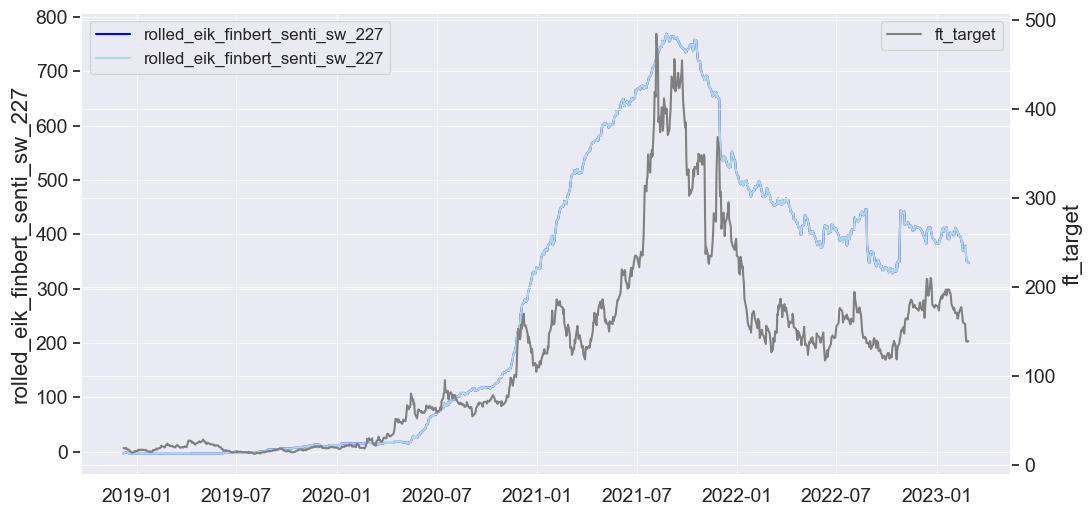

In [69]:
plot_three_line_chart(comp_pred_df_senti, "datetime", "rolled_vader_tw_sw_normalized_17", "ft_target","rolled_eik_finbert_senti_sw_227")

In [106]:
Ssenti_vars = ["rolled_Vader_sentim_351","rolled_eik_vader_senti_sw_21"]#  -> best results so far moderna
#Ssenti_vars = []

Ssenti_vars = ["rolled_textblob_eik_twi_senti_327", "rolled_finbert_senti_sw_65","rolled_Vader_sentim_41"]

Ssenti_vars = []

In [107]:
all_feat = date + macro_vars + google_vars + lagged_vars + techni_vars + fama_vars + ft_target + Ssenti_vars #+ Csenti_vars
modelling_ft = macro_vars + google_vars + lagged_vars + techni_vars + fama_vars + Ssenti_vars #+ Csenti_vars
comp_pred_final = comp_pred_final_df[all_feat]
comp_pred_final = comp_pred_final.iloc[:-1,:]

In [108]:
comp_pred_final = comp_pred_final[comp_pred_final["datetime"] <= "2023-02-15 00:00:00+00:00"]

In [101]:
X = comp_pred_final[modelling_ft]

In [102]:
y = comp_pred_final["ft_target"]

In [97]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression

# Assuming you have your data X and target variable y

# Define the estimator (model) for regression
estimator = LinearRegression()

# Specify the number of features to select
k_features_to_select = 30

# Create the SelectKBest object with mutual information criterion
selector = SelectKBest(mutual_info_regression, k=k_features_to_select)

# Fit the selector to your data
selector.fit(X, y)

# Get the selected variables and their scores
selected_variables = X.columns[selector.get_support()]
feature_scores = selector.scores_

# Sort the selected variables based on their scores in descending order
selected_variables_sorted = [x for _, x in sorted(zip(feature_scores, selected_variables), reverse=True)]
feature_scores_sorted = sorted(feature_scores, reverse=True)

# Print the ranked selected variables and their scores
for rank, (variable, score) in enumerate(zip(selected_variables_sorted, feature_scores_sorted), start=1):
    print(f"Rank: {rank}, Variable: {variable}, Score: {score}")


Rank: 1, Variable: rolled_finbert_senti_sw_65, Score: 0.08280359482917188
Rank: 2, Variable: low, Score: 0.08080557175858338
Rank: 3, Variable: rolled_Vader_sentim_41, Score: 0.07962048788272735
Rank: 4, Variable: rolled_textblob_tw_sw_norm_245, Score: 0.0788860861004177
Rank: 5, Variable: rolled_textblob_tw_sw_norm_259, Score: 0.07879402469896224
Rank: 6, Variable: rolled_textblob_eik_twi_senti_327, Score: 0.07852880249763405
Rank: 7, Variable: rolled_vader_tw_sw_normalized_285, Score: 0.07773872825777373
Rank: 8, Variable: rolled_vader_tw_sw_normalized_297, Score: 0.07664011766848544
Rank: 9, Variable: rolled_vader_tw_sw_normalized_287, Score: 0.07636853320482784
Rank: 10, Variable: rolled_vader_tw_sw_normalized_281, Score: 0.07625539333122822
Rank: 11, Variable: rolled_vader_tw_sw_normalized_283, Score: 0.07569982128545849
Rank: 12, Variable: rolled_textblob_eik_twi_senti_329, Score: 0.07557310055643551
Rank: 13, Variable: rolled_textblob_tw_sw_norm_267, Score: 0.07465456951316263
R

In [109]:
#xgboost_test = {'xgboost': {'alpha_estimation_method':'Lasso', "alpha": 0.0}}
xgboost_test = {'xgboost': {'alpha_estimation_method':'xgboost'}}

In [110]:
all_results_df = pd.read_csv(modelling_data_path + "/results_summary.csv", index_col =[0])
all_results_df = all_results_df.drop_duplicates()

company = "moderna"
target = "ret"
variables = "all"
sentiment = "False"
model = "xgboost"
comments = "newst combo sentiment scores "

counter = len(all_results_df)
from class_backtester import Backtester as bk 
backtester = bk(df = comp_pred_final, 
                params = None,
                modeling_features = modelling_ft,
                rolling_frw = '1D',
                look_back_prm = 252, 
                configurations= xgboost_test, 
                col_to_pred = 'ft_target',
                days_avoid_bias = 0)

backtester.run_backtest()

track_results = {}
resutls_df = backtester.dict_all_predictions["xgboost"][["datetime", "ft_target","ft_target_pred"]]
resutls_df['y_test'] = (resutls_df['ft_target'] > resutls_df['ft_target'].shift()).astype(int)
resutls_df['y_test'] = resutls_df['y_test'].fillna(0)
resutls_df['y_pred'] = (resutls_df['ft_target_pred'] > resutls_df['ft_target_pred'].shift()).astype(int)
resutls_df['y_pred'] = resutls_df['y_pred'].fillna(0)
resutls_df = resutls_df.set_index("datetime")
track_results["trial_"+str(counter)] = {}
track_results["trial_"+str(counter)]["company"] = company
track_results["trial_"+str(counter)]["target"] = target
track_results["trial_"+str(counter)]["variables"] = variables
track_results["trial_"+str(counter)]["sentiment"] = sentiment
track_results["trial_"+str(counter)]["model"] = model
track_results["trial_"+str(counter)]["comments"] = comments
track_results["trial_"+str(counter)]["precision"] = precision_score(resutls_df["y_test"], resutls_df["y_pred"])
track_results["trial_"+str(counter)]["recall"] = recall_score(resutls_df["y_test"], resutls_df["y_pred"])
track_results["trial_"+str(counter)]["accuracy"] = accuracy_score(resutls_df["y_test"], resutls_df["y_pred"])
track_results["trial_"+str(counter)]["f1_score"] = f1_score(resutls_df["y_test"], resutls_df["y_pred"])
track_results["trial_"+str(counter)]["mae"] = round(mean_absolute_percentage_error(resutls_df.iloc[:,:2]["ft_target"], resutls_df.iloc[:,:2]["ft_target_pred"]),5)*100
track_results["trial_"+str(counter)]["datetime"] = list(resutls_df["ft_target"].index)
track_results["trial_"+str(counter)]["y_test"] = list(resutls_df["ft_target"].values)
track_results["trial_"+str(counter)]["y_pred"] = list(resutls_df["ft_target_pred"].values)
results_df = pd.DataFrame.from_dict(track_results, orient='index')
all_results_df = pd.concat([all_results_df, results_df])
all_results_df.to_csv(modelling_data_path + "/results_summary.csv")

100%|██████████| 1278/1278 [00:41<00:00, 30.91it/s]


In [111]:
all_results_df = pd.read_csv(modelling_data_path + "/results_summary.csv", index_col =[0])
all_results_df

,company,target,variables,sentiment,model,comments,precision,recall,accuracy,f1_score,mae,datetime,y_test,y_pred
trial_2,moderna,close,all,True,xgboost,default scores,0.514412,0.524887,0.512500,0.519597,4.764,"DatetimeIndex(['2019-08-16 00:00:00+00:00', '2...",[[ 13.4 ]\n [ 14.15 ]\n [ 14.29 ]\n [ 14.16 ]...,[ 12.910629 13.068525 13.749891 13.827463 ...
trial_1,moderna,close,all,False,xgboost,default scores,0.500000,0.513575,0.497727,0.506696,4.837,"DatetimeIndex(['2019-08-16 00:00:00+00:00', '2...",[[ 13.4 ]\n [ 14.15 ]\n [ 14.29 ]\n [ 14.16 ]...,[ 12.922419 13.128277 13.511124 13.75116...
trial_2,moderna,close,all,False,xgboost,default scores,0.514412,0.524887,0.512500,0.519597,4.764,"DatetimeIndex(['2019-08-16 00:00:00+00:00', '2...",[[ 13.4 ]\n [ 14.15 ]\n [ 14.29 ]\n [ 14.16 ]...,[ 12.910629 13.068525 13.749891 13.827463 ...
trial_3,moderna,close,all,True,xgboost,newst sentiment scores,0.496760,0.520362,0.494318,0.508287,4.873,"[Timestamp('2019-08-16 00:00:00+0000', tz='UTC...","[array([13.4]), array([14.15]), array([14.29])...","[13.145462, 13.040613, 13.867473, 13.849922, 1..."
trial_4,moderna,close,all,True,xgboost,newst sentiment scores,0.496760,0.520362,0.494318,0.508287,4.873,"[Timestamp('2019-08-16 00:00:00+0000', tz='UTC...","[13.4, 14.15, 14.29, 14.16, 13.88, 14.97, 14.5...","[13.145462, 13.040613, 13.867473, 13.849922, 1..."
trial_5,moderna,close,all,True,xgboost,newst combo sentiment scores,0.512931,0.538462,0.511364,0.525386,4.797,"[Timestamp('2019-08-16 00:00:00+0000', tz='UTC...","[13.4, 14.15, 14.29, 14.16, 13.88, 14.97, 14.5...","[13.145688, 12.934818, 13.749891, 13.847528, 1..."
trial_6,moderna,ret,all,True,xgboost,newst combo sentiment scores,0.482679,0.472851,0.480682,0.477714,417.712,"[Timestamp('2019-08-16 00:00:00+0000', tz='UTC...","[0.0182370820668693, 0.0559701492537313, 0.009...","[-0.029034533, -0.019214138, 0.001191173, 0.02..."
trial_7,moderna,ret,all,False,xgboost,newst combo sentiment scores,0.466819,0.461538,0.464773,0.464164,422.338,"[Timestamp('2019-08-16 00:00:00+0000', tz='UTC...","[0.0182370820668693, 0.0559701492537313, 0.009...","[0.02222908, -0.033050414, -0.006797088, 0.014..."


In [384]:
resutls_df

,ft_target,ft_target_pred,y_test,y_pred
datetime,,,,
2019-08-16 00:00:00+00:00,13.40,12.910629,0,0
2019-08-19 00:00:00+00:00,14.15,13.068525,1,1
2019-08-20 00:00:00+00:00,14.29,13.749891,1,1
2019-08-21 00:00:00+00:00,14.16,13.827463,0,1
2019-08-22 00:00:00+00:00,13.88,14.078301,0,1
...,...,...,...,...
2023-02-07 00:00:00+00:00,164.34,175.132111,0,1
2023-02-08 00:00:00+00:00,164.48,166.991592,1,0
2023-02-09 00:00:00+00:00,169.28,163.613632,1,0


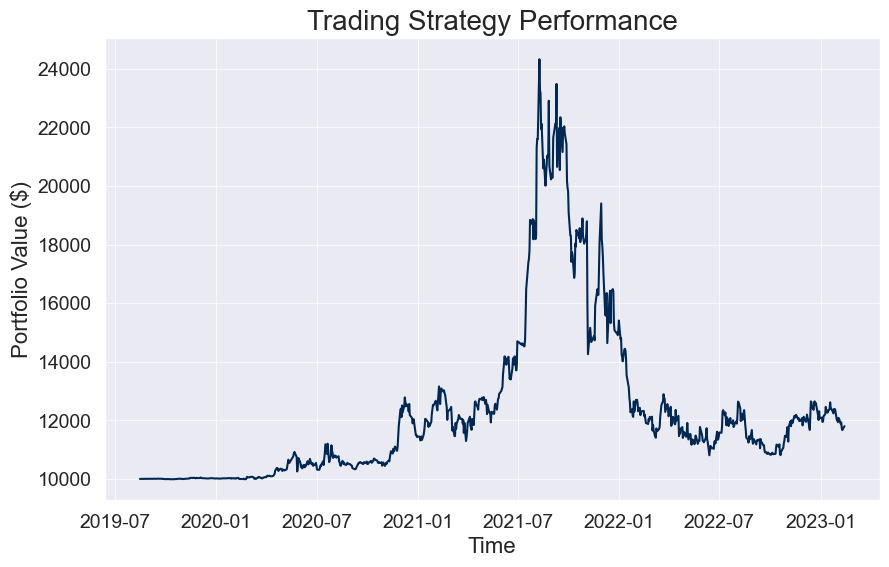

Final Portfolio Value: $ 11800.205700874329


In [385]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe
# Assuming your dataframe is named 'results_df'
df = resutls_df.copy()

# Create a new column for trading decisions
df['Decision'] = df['ft_target_pred'].diff()

# Define the trading strategy
df['Position'] = 0  # Initialize the 'Position' column
df.loc[df['Decision'] > 0, 'Position'] = 1  # Buy
df.loc[df['Decision'] < 0, 'Position'] = -1  # Sell

# Calculate the portfolio value
initial_capital = 10000
df['Holdings'] = df['Position'].cumsum() * df['ft_target_pred']
df['Cash'] = initial_capital - (df['Position'] * df['ft_target_pred']).cumsum()
df['PortfolioValue'] = df['Cash'] + df['Holdings']

# Visualize the portfolio value
plt.plot(df['PortfolioValue'])
plt.title('Trading Strategy Performance')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.show()

# Calculate and print the final portfolio value
final_portfolio_value = df['PortfolioValue'].iloc[-1]
print("Final Portfolio Value: $", final_portfolio_value)

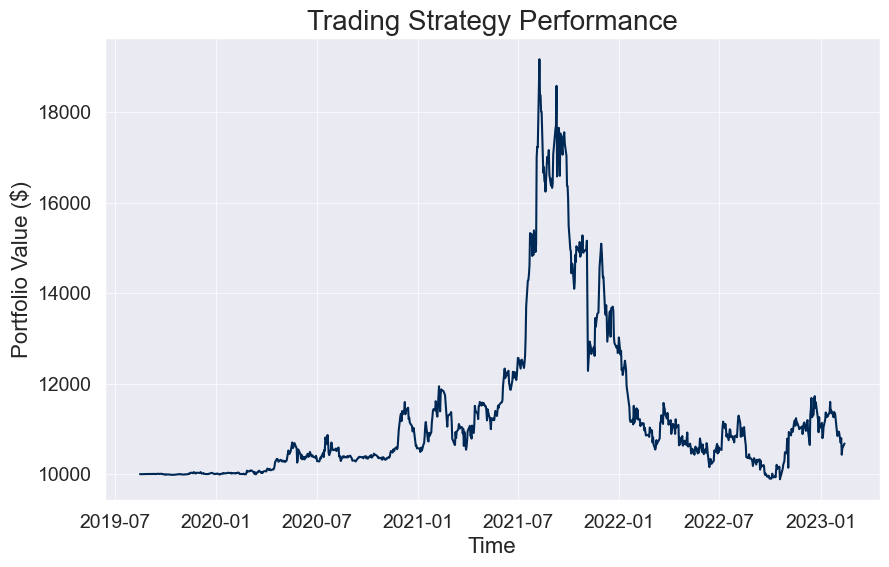

Final Portfolio Value: $ 10677.87132358551


In [378]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe
# Assuming your dataframe is named 'results_df'
df = resutls_df.copy()

# Create a new column for trading decisions
df['Decision'] = df['ft_target_pred'].diff()

# Define the trading strategy
df['Position'] = 0  # Initialize the 'Position' column
df.loc[df['Decision'] > 0, 'Position'] = 1  # Buy
df.loc[df['Decision'] < 0, 'Position'] = -1  # Sell

# Calculate the portfolio value
initial_capital = 10000
df['Holdings'] = df['Position'].cumsum() * df['ft_target_pred']
df['Cash'] = initial_capital - (df['Position'] * df['ft_target_pred']).cumsum()
df['PortfolioValue'] = df['Cash'] + df['Holdings']

# Visualize the portfolio value
plt.plot(df['PortfolioValue'])
plt.title('Trading Strategy Performance')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.show()

# Calculate and print the final portfolio value
final_portfolio_value = df['PortfolioValue'].iloc[-1]
print("Final Portfolio Value: $", final_portfolio_value)


---
### Statistically Significant Variables 

In [74]:
import statsmodels.api as sm

In [88]:
modelling_ft_2 = modelling_ft[:30]

In [89]:
X = comp_pred_final[modelling_ft_2]
y = comp_pred_final["ft_target"]

In [90]:
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ft_target   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     5535.
Date:                Thu, 11 May 2023   Prob (F-statistic):               0.00
Time:                        21:28:11   Log-Likelihood:                -3695.0
No. Observations:                1055   AIC:                             7452.
Df Residuals:                    1024   BIC:                             7606.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3730      8

In [102]:
no_sentiment = resutls_df.copy()

In [103]:
no_sentiment["noSenti_resi"] = abs(no_sentiment["ft_target"] - no_sentiment["ft_target_pred"])
no_sentiment["noSenti_resi"] = no_sentiment["noSenti_resi"].rolling(31).mean()
resutls_df["Senti_resi"] = abs(resutls_df["ft_target"] - resutls_df["ft_target_pred"])
resutls_df["Senti_resi"] = resutls_df["Senti_resi"].rolling(31).mean()

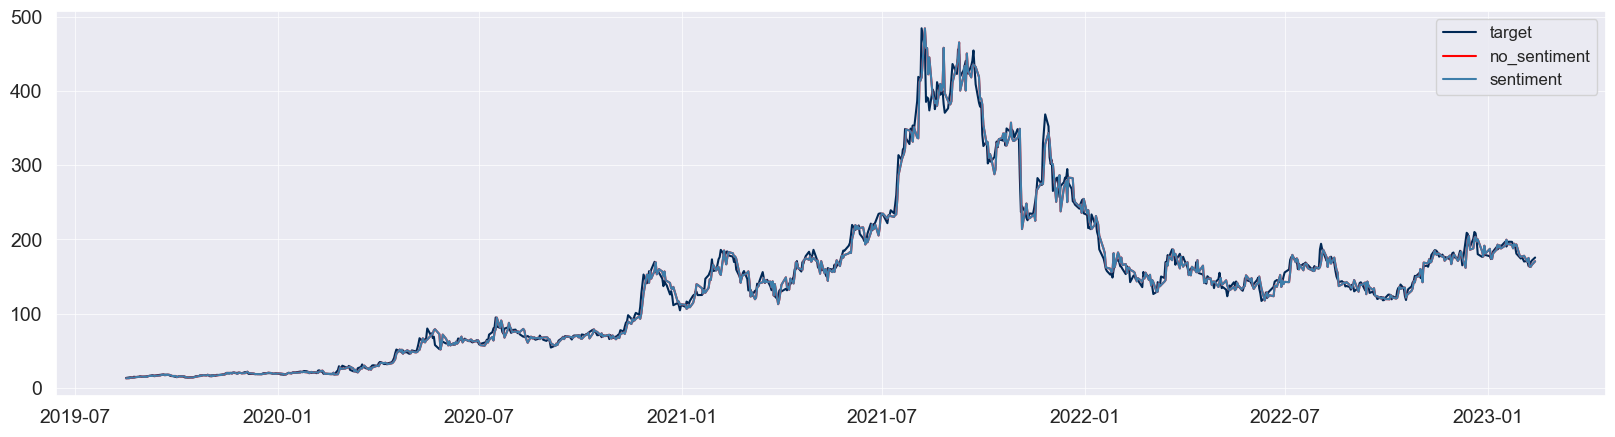

In [104]:
plt.figure(figsize=(20,5))
plt.plot(no_sentiment.index, no_sentiment.ft_target)
plt.plot(no_sentiment.index, no_sentiment.ft_target_pred, color = "red")
plt.plot(resutls_df.index, resutls_df.ft_target_pred)
plt.legend(["target", "no_sentiment", "sentiment"])
plt.show()

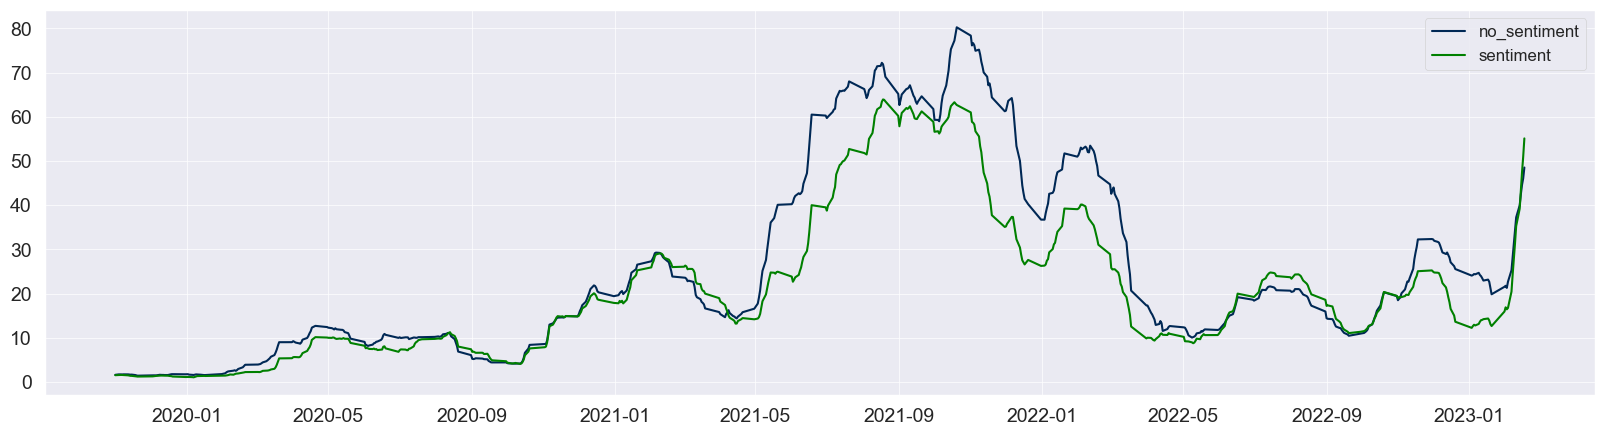

In [674]:
plt.figure(figsize=(20,5))
plt.plot(no_sentiment.index, no_sentiment.noSenti_resi)
plt.plot(resutls_df.index, resutls_df.Senti_resi, color = "green")
plt.legend(["no_sentiment", "sentiment"])
plt.show()

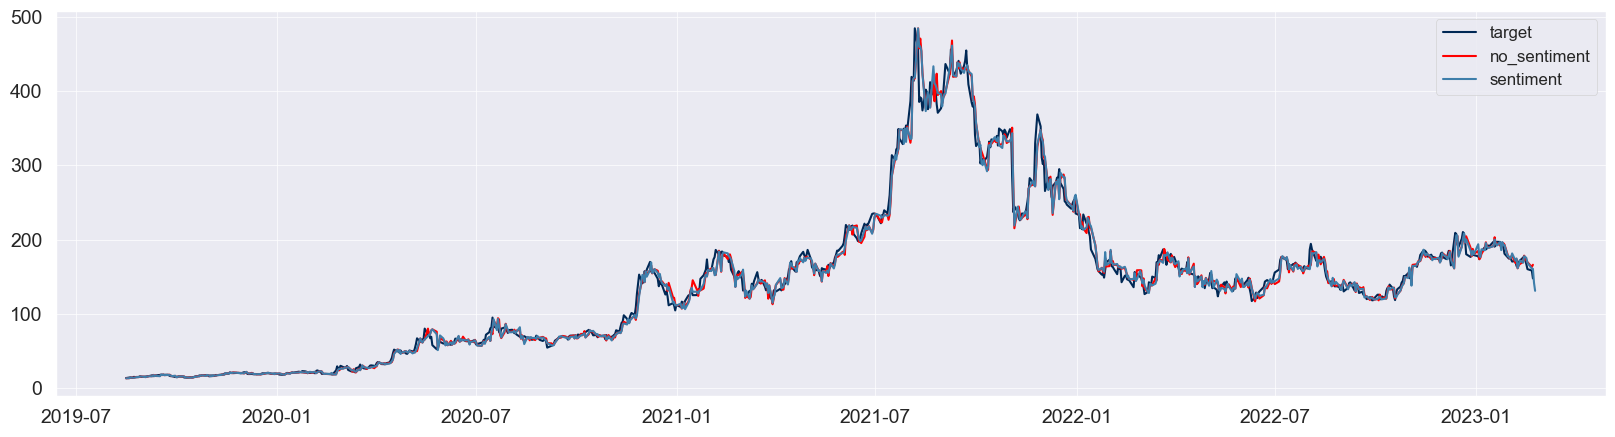

In [579]:
plt.figure(figsize=(20,5))
plt.plot(no_sentiment.index, no_sentiment.ft_target)
plt.plot(no_sentiment.index, no_sentiment.ft_target_pred, color = "red")
plt.plot(resutls_df.index, resutls_df.ft_target_pred)
plt.legend(["target", "no_sentiment", "sentiment"])
plt.show()

In [632]:
no_sentiment["noSenti_resi"] = abs(no_sentiment["ft_target"] - no_sentiment["ft_target_pred"])
no_sentiment["noSenti_resi"] = no_sentiment["noSenti_resi"].rolling(365).mean()
resutls_df["Senti_resi"] = abs(resutls_df["ft_target"] - resutls_df["ft_target_pred"])
resutls_df["Senti_resi"] = resutls_df["Senti_resi"].rolling(365).mean()

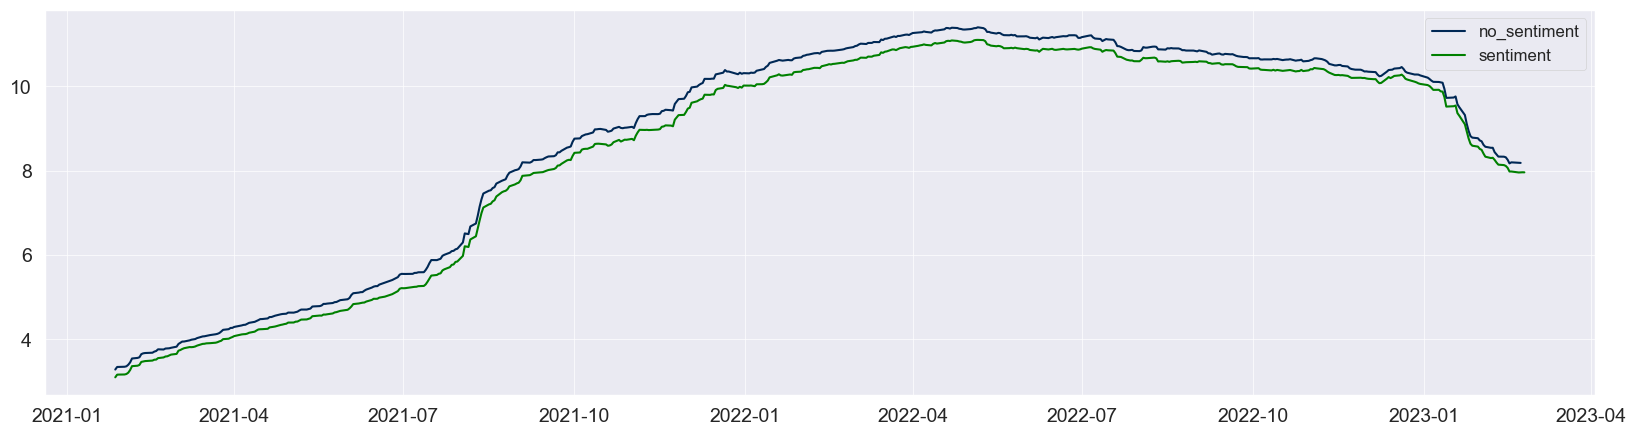

In [605]:
plt.figure(figsize=(20,5))
plt.plot(no_sentiment.index, no_sentiment.noSenti_resi)
plt.plot(resutls_df.index, resutls_df.Senti_resi, color = "green")
plt.legend(["no_sentiment", "sentiment"])
plt.show()